<a href="https://colab.research.google.com/github/Shubhammehta2005/ECE501_2025_8_Pixels/blob/main/Codes/Hybrid_dwt_dct_and_Hybrid_dwt_dct_svd_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hybrid dwt-dct**

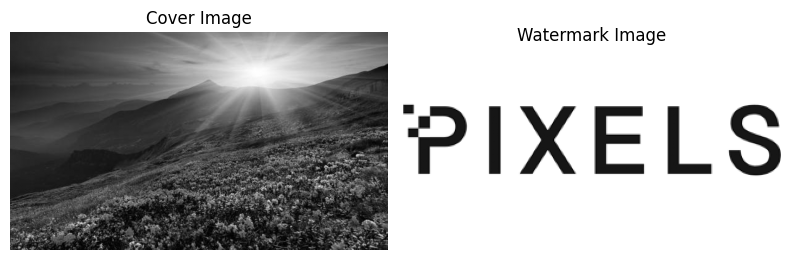

In [ ]:
# Block A — common utilities and display original images
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt

def ensure_even_subbands(LL, LH, HL, HH):
    """Crop all subbands to even sizes (same shape) to satisfy cv2.dct requirements."""
    h, w = HL.shape
    new_h = h - (h % 2)
    new_w = w - (w % 2)
    if new_h != h or new_w != w:
        LL = LL[:new_h, :new_w]
        LH = LH[:new_h, :new_w]
        HL = HL[:new_h, :new_w]
        HH = HH[:new_h, :new_w]
    return LL, LH, HL, HH

def embed_watermark(cover_img, watermark_img, alpha=0.05):
    """
    Embed watermark into cover_img using DWT+DCT (non-blind: requires original DCT for extraction).
    Returns watermarked_img (uint8) and the original dct_sub_band used for extraction.
    """
    # 1-level DWT
    coeffs2 = pywt.dwt2(cover_img, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Ensure even sizes for subbands
    LL, LH, HL, HH = ensure_even_subbands(LL, LH, HL, HH)
    sub_band = HL  # use HL for embedding

    # DCT on chosen sub-band
    dct_sub_band = cv2.dct(np.float32(sub_band))

    # Resize watermark to DCT sub-band shape
    wm_resized = cv2.resize(watermark_img, (dct_sub_band.shape[1], dct_sub_band.shape[0]))
    wm_resized = wm_resized.astype(np.float32)

    # Embed (modify DCT coefficients)
    watermarked_dct = dct_sub_band + alpha * wm_resized

    # Inverse DCT on sub-band
    watermarked_sub_band = cv2.idct(watermarked_dct)

    # Reconstruct image using inverse DWT (use modified HL)
    watermarked_coeffs = (LL, (LH, watermarked_sub_band, HH))
    watermarked_img = pywt.idwt2(watermarked_coeffs, 'haar')

    watermarked_img = np.uint8(np.clip(watermarked_img, 0, 255))

    return watermarked_img, dct_sub_band

def extract_watermark(w_image, original_dct_sub_band, alpha=0.05):
    """
    Extract watermark using the non-blind method (requires original DCT sub-band used before embedding).
    Returns extracted watermark (uint8).
    """
    coeffs2_w = pywt.dwt2(w_image, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2_w

    # Crop HL_w if necessary to match original_dct_sub_band shape
    h0, w0 = original_dct_sub_band.shape
    HL_w_cropped = HL_w[:h0, :w0]

    # DCT of the attacked/received sub-band
    dct_w = cv2.dct(np.float32(HL_w_cropped))

    # Extract watermark approx
    extracted = (dct_w - original_dct_sub_band) / alpha
    extracted = np.uint8(np.clip(extracted, 0, 255))
    return extracted

# Load images (grayscale)
cover_img = cv2.imread("cover.png", cv2.IMREAD_GRAYSCALE)
watermark_img = cv2.imread("watermark.png", cv2.IMREAD_GRAYSCALE)

if cover_img is None or watermark_img is None:
    raise FileNotFoundError("Make sure 'cover.png' and 'watermark.png' exist in the working folder.")

# Show original cover and watermark
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Cover Image")
plt.imshow(cover_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Watermark Image")
plt.imshow(watermark_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Block 1 — normal (clean) case
alpha = 0.03

# Embed
watermarked_img, orig_dct = embed_watermark(cover_img, watermark_img, alpha=alpha)
cv2.imwrite("watermarked_clean.png", watermarked_img)

# Extract from the clean watermarked image
extracted_clean = extract_watermark(watermarked_img, orig_dct, alpha=alpha)
cv2.imwrite("extracted_clean.png", extracted_clean)

# Display results
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Cover")
plt.imshow(cover_img, cmap='gray'); plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked (clean)")
plt.imshow(watermarked_img, cmap='gray'); plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted WM (clean)")
plt.imshow(extracted_clean, cmap='gray'); plt.axis('off')

plt.tight_layout(); plt.show()


NameError: name 'embed_watermark' is not defined

# **Added noise**

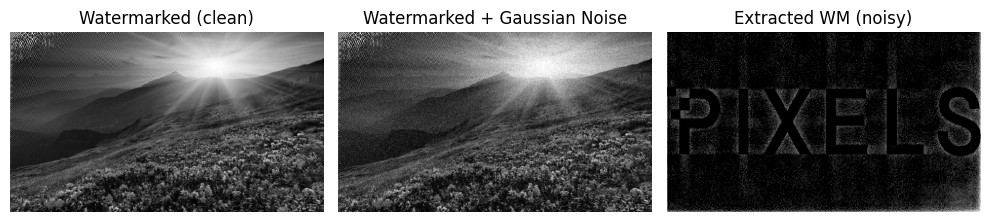

In [ ]:
# Block 2 — noisy attack
sigma = 15  # noise standard deviation; tweak to make it stronger/weaker

# Create noisy version
noise = np.random.normal(0, sigma, watermarked_img.shape)
noisy_watermarked = np.uint8(np.clip(watermarked_img.astype(np.float32) + noise, 0, 255))
cv2.imwrite("watermarked_noisy.png", noisy_watermarked)

# Extract watermark from noisy image
extracted_noisy = extract_watermark(noisy_watermarked, orig_dct, alpha=alpha)
cv2.imwrite("extracted_noisy.png", extracted_noisy)

# Display
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Watermarked (clean)")
plt.imshow(watermarked_img, cmap='gray'); plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked + Gaussian Noise")
plt.imshow(noisy_watermarked, cmap='gray'); plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted WM (noisy)")
plt.imshow(extracted_noisy, cmap='gray'); plt.axis('off')

plt.tight_layout(); plt.show()


# **Added compression and small scale rotation**

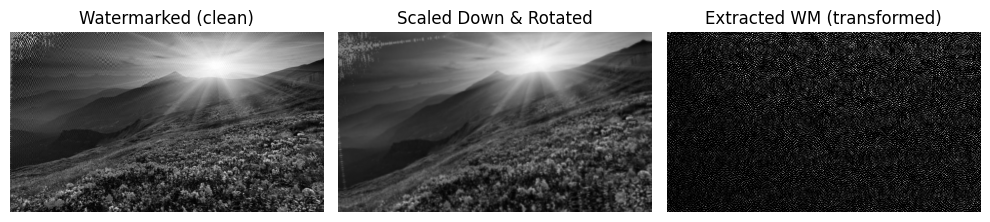

In [ ]:
# Block 3 — geometric attack: resize then rotate
# Resize down and up to simulate lossy scaling, then rotate slightly
h, w = watermarked_img.shape
# scale down
small = cv2.resize(watermarked_img, (w//2, h//2), interpolation=cv2.INTER_LINEAR)
# scale up (introduces interpolation blur)
scaled_back = cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)
# rotate by a small angle around center
M = cv2.getRotationMatrix2D((w/2, h/2), angle=7, scale=1.0)  # rotate by 7 degrees
rotated = cv2.warpAffine(scaled_back, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

cv2.imwrite("watermarked_scaled_rotated.png", rotated)

# Extract watermark from transformed image
extracted_transformed = extract_watermark(rotated, orig_dct, alpha=alpha)
cv2.imwrite("extracted_transformed.png", extracted_transformed)

# Display
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Watermarked (clean)")
plt.imshow(watermarked_img, cmap='gray'); plt.axis('off')

plt.subplot(1,3,2)
plt.title("Scaled Down & Rotated")
plt.imshow(rotated, cmap='gray'); plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted WM (transformed)")
plt.imshow(extracted_transformed, cmap='gray'); plt.axis('off')

plt.tight_layout(); plt.show()


# **HYBRID DWT-DCT-SVD model**


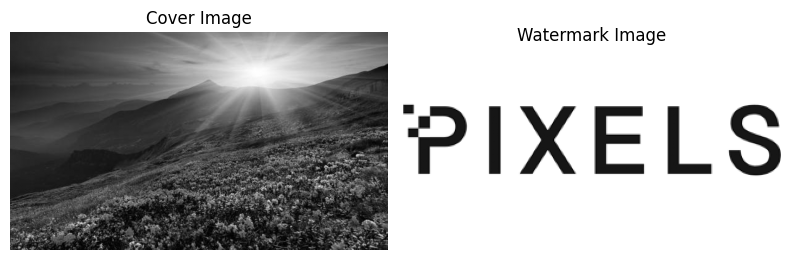

In [ ]:
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt

def embed_svd_watermark(cover_img, watermark_img, alpha=0.05):
    coeffs2 = pywt.dwt2(cover_img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    HL = HL.astype(np.float32)

    dct_sub = cv2.dct(HL)
    U, S, Vt = np.linalg.svd(dct_sub, full_matrices=False)

    wm_float = cv2.resize(watermark_img, (HL.shape[1], HL.shape[0])).astype(np.float32)
    Uw, Sw, Vwt = np.linalg.svd(wm_float, full_matrices=False)

    S_emb = S + alpha * Sw
    dct_embedded = np.dot(U, np.dot(np.diag(S_emb), Vt))

    HL_wm = cv2.idct(dct_embedded)
    watermarked_coeffs = (LL, (LH, HL_wm, HH))
    watermarked_img = pywt.idwt2(watermarked_coeffs, 'haar')
    watermarked_img = np.uint8(np.clip(watermarked_img, 0, 255))
    return watermarked_img, S, U, Vt, Uw, Vwt, Sw, HL.shape

def extract_svd_watermark(watermarked_img, S_orig, U, Vt, Uw, Vwt, alpha=0.05, shape=None):
    coeffs2_w = pywt.dwt2(watermarked_img, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2_w
    if shape is not None:
        HL_w = HL_w[:shape[0], :shape[1]]
    dct_w = cv2.dct(HL_w.astype(np.float32))
    Uw_w, Sw_w, Vwt_w = np.linalg.svd(dct_w, full_matrices=False)
    Sw_extracted = (Sw_w - S_orig) / alpha
    wm_extracted = np.dot(Uw, np.dot(np.diag(Sw_extracted), Vwt))
    wm_extracted = np.uint8(np.clip(wm_extracted, 0, 255))
    return wm_extracted

# Load images
cover_img = cv2.imread("cover.png", cv2.IMREAD_GRAYSCALE)
watermark_img = cv2.imread("watermark.png", cv2.IMREAD_GRAYSCALE)

# Show original images
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Cover Image")
plt.imshow(cover_img, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
plt.title("Watermark Image")
plt.imshow(watermark_img, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.show()


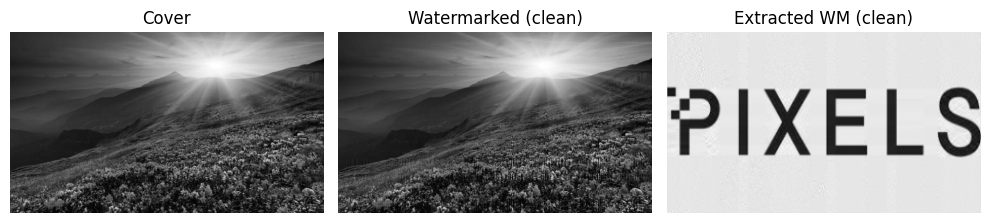

In [ ]:
alpha = 0.05

watermarked_img, S_orig, U, Vt, Uw, Vwt, Sw, hl_shape = embed_svd_watermark(cover_img, watermark_img, alpha)
cv2.imwrite("watermarked_svd.png", watermarked_img)

extracted_wm = extract_svd_watermark(watermarked_img, S_orig, U, Vt, Uw, Vwt, alpha, shape=hl_shape)
cv2.imwrite("extracted_svd.png", extracted_wm)

# Display
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Cover")
plt.imshow(cover_img, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2)
plt.title("Watermarked (clean)")
plt.imshow(watermarked_img, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3)
plt.title("Extracted WM (clean)")
plt.imshow(extracted_wm, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.show()


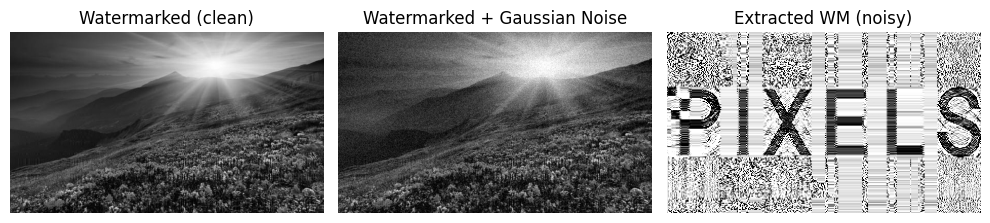

In [ ]:
sigma = 15
noise = np.random.normal(0, sigma, watermarked_img.shape)
noisy_watermarked = np.uint8(np.clip(watermarked_img.astype(np.float32) + noise, 0, 255))
cv2.imwrite("watermarked_noisy_svd.png", noisy_watermarked)

extracted_noisy = extract_svd_watermark(noisy_watermarked, S_orig, U, Vt, Uw, Vwt, alpha, shape=hl_shape)
cv2.imwrite("extracted_noisy_svd.png", extracted_noisy)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Watermarked (clean)")
plt.imshow(watermarked_img, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2)
plt.title("Watermarked + Gaussian Noise")
plt.imshow(noisy_watermarked, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3)
plt.title("Extracted WM (noisy)")
plt.imshow(extracted_noisy, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.show()


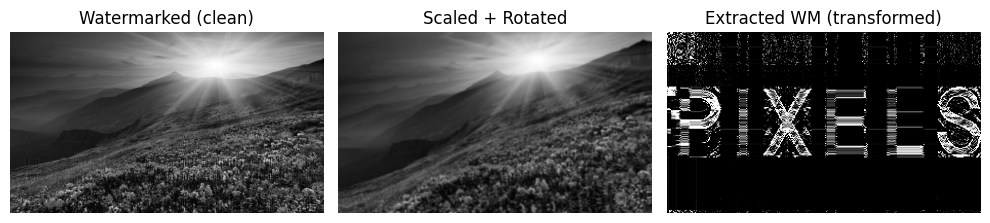

In [ ]:
h, w = watermarked_img.shape
# Scale down then up
small = cv2.resize(watermarked_img, (w//2, h//2), interpolation=cv2.INTER_LINEAR)
scaled_back = cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)
# Rotate slightly
M = cv2.getRotationMatrix2D((w/2, h/2), 7, 1.0)
rotated = cv2.warpAffine(scaled_back, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
cv2.imwrite("watermarked_scaled_rotated_svd.png", rotated)

extracted_transformed = extract_svd_watermark(rotated, S_orig, U, Vt, Uw, Vwt, alpha, shape=hl_shape)
cv2.imwrite("extracted_transformed_svd.png", extracted_transformed)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Watermarked (clean)")
plt.imshow(watermarked_img, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2)
plt.title("Scaled + Rotated")
plt.imshow(rotated, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3)
plt.title("Extracted WM (transformed)")
plt.imshow(extracted_transformed, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.show()
